In [3]:
import pennylane as qml
from autograd import grad

In [4]:
################ Code from the 'Optimization of molecular geometries' tutorial##################
# imports and relevant defines:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
import time

# Simulation starting parameters:
symbols = ["O", "H", "H"]

# np.array([ 0.        ,  0.7581    , -0.5086    , -1.49139892,  0.29819887,
#        -1.2393812 , -0.68850404,  2.16155953,  0.21671681], requires_grad=True)

# this is selected from the tutorial 'Building molecular Hamiltonians', which has the same nulcear-coordinats for water
x = np.array([[0.        ,  0.7581    , -0.5086],
              [-1.49139892,  0.29819887, -1.2393812],
              [-0.68850404,  2.16155953,  0.21671681]], requires_grad=True)
# these parameters are used to match up with the parameters for the VQE run on water in the paper: https://arxiv.org/pdf/2106.13840.pdf
active_electrons = 8
active_orbitals = 6

# define the hamiltonian needed to compute cost-function
def H(x):
    return qml.qchem.molecular_hamiltonian(symbols, x, charge=0, active_electrons = active_electrons,
                                           active_orbitals = active_orbitals)[0]

hf = qml.qchem.hf_state(electrons=active_electrons, orbitals=active_orbitals*2)
print(hf)

[1 1 1 1 1 1 1 1 0 0 0 0]


In [5]:
# Need to run this: functions to allow us to calculate angle between OH1 and OH2:
import math

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return (np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)) * 180/math.pi) #convert to degrees

In [6]:
################ Code from the 'Building the adaptive circuit' tutorial below:################
active_electrons = active_electrons
active_orbitals = active_orbitals

H, qubits = qml.qchem.molecular_hamiltonian(symbols, x, charge=0, active_electrons = active_electrons, active_orbitals = active_orbitals)
singles, doubles = qchem.excitations(active_electrons, qubits)

hf_state = qchem.hf_state(active_electrons, qubits)
print(hf_state)



#compute the significant double-excitation gates:
def circuit_1(params, excitations):
    qml.BasisState(hf_state, wires=range(qubits))

    for i, excitation in enumerate(excitations):
        if len(excitation) == 4:
            qml.DoubleExcitation(params[i], wires=excitation)
        else:
            qml.SingleExcitation(params[i], wires=excitation)
    return qml.expval(H)

dev = qml.device("default.qubit", wires=qubits)
cost_fn = qml.QNode(circuit_1, dev, interface="autograd")
circuit_gradient = qml.grad(cost_fn, argnum=0)
params = [0.0] * len(doubles)
grads = circuit_gradient(params, excitations=doubles)
print("Computed gradients for all possible Double Excitation Gates: \n")
for i in range(len(doubles)):
    print(f"Excitation : {doubles[i]}, Gradient: {grads[i]}")   
doubles_select = [doubles[i] for i in range(len(doubles)) if abs(grads[i]) > 1.0e-5]
print("")
print("Number of selected double-excitation gates: ", len(doubles_select))



# optimizing the parameters for the double-excitation gates for Ansatz-wavefunction construction
opt = qml.GradientDescentOptimizer(stepsize=0.5)
params_doubles = np.zeros(len(doubles_select), requires_grad=True)
for n in range(20):
    params_doubles = opt.step(cost_fn, params_doubles, excitations=doubles_select)
print("Done!")



#compute the significant single-excitation gates:
def circuit_2(params, excitations, gates_select, params_select):
    qml.BasisState(hf_state, wires=range(qubits))

    for i, gate in enumerate(gates_select):
        if len(gate) == 4:
            qml.DoubleExcitation(params_select[i], wires=gate)
        elif len(gate) == 2:
            qml.SingleExcitation(params_select[i], wires=gate)

    for i, gate in enumerate(excitations):
        if len(gate) == 4:
            qml.DoubleExcitation(params[i], wires=gate)
        elif len(gate) == 2:
            qml.SingleExcitation(params[i], wires=gate)
    return qml.expval(H)


cost_fn = qml.QNode(circuit_2, dev, interface="autograd")
circuit_gradient = qml.grad(cost_fn, argnum=0)
params = [0.0] * len(singles)
grads = circuit_gradient(
    params,
    excitations=singles,
    gates_select=doubles_select,
    params_select=params_doubles
)
print("Computed gradients for all possible Single Excitation Gates: \n")
for i in range(len(singles)):
    print(f"Excitation : {singles[i]}, Gradient: {grads[i]}")
singles_select = [singles[i] for i in range(len(singles)) if abs(grads[i]) > 1.0e-5]
print("")
print("Number of selected single-excitation gates: ", len(singles_select))

#Total Number of Gates selected to construct the Quantum Ansatz:
print("Total selected gates: "+  str(len(doubles_select) + len(singles_select)))

################# End code from the 'Building the adaptive circuit' tutorial ##################

[1 1 1 1 1 1 1 1 0 0 0 0]
Computed gradients for all possible Double Excitation Gates: 

Excitation : [0, 1, 8, 9], Gradient: -0.10631894572187418
Excitation : [0, 1, 8, 11], Gradient: 0.0
Excitation : [0, 1, 9, 10], Gradient: 0.0
Excitation : [0, 1, 10, 11], Gradient: -0.059240875717551184
Excitation : [0, 2, 8, 10], Gradient: -0.039875832213294854
Excitation : [0, 3, 8, 9], Gradient: 0.0
Excitation : [0, 3, 8, 11], Gradient: 0.0772097850362808
Excitation : [0, 3, 9, 10], Gradient: -0.03733395282298593
Excitation : [0, 3, 10, 11], Gradient: 0.0
Excitation : [0, 4, 8, 10], Gradient: 0.0
Excitation : [0, 5, 8, 9], Gradient: 0.05732746246971731
Excitation : [0, 5, 8, 11], Gradient: 0.0
Excitation : [0, 5, 9, 10], Gradient: 0.0
Excitation : [0, 5, 10, 11], Gradient: -0.014036506114198311
Excitation : [0, 6, 8, 10], Gradient: 0.0
Excitation : [0, 7, 8, 9], Gradient: 0.0
Excitation : [0, 7, 8, 11], Gradient: 0.0
Excitation : [0, 7, 9, 10], Gradient: 0.0
Excitation : [0, 7, 10, 11], Gradient

In [7]:
# End of ADAPT VQE ^ 
# Now use Soran's modified code down below:


symbols = ["O", "H", "H"]
geometry = np.array([[0.        ,  0.7581    , -0.5086],
              [-1.49139892,  0.29819887, -1.2393812],
              [-0.68850404,  2.16155953,  0.21671681]], requires_grad=True)
mol = qml.qchem.Molecule(symbols, geometry)
dev = qml.device("default.qubit")

# Factor to convert from Bohrs to Angstroms
bohr_angs = 0.529177210903

In [8]:
def energy(mol):
    @qml.qnode(dev, interface="autograd")
    def circuit(*args):
        
        # note that active_electrons=2, active_orbitals=2 in this example
        qml.BasisState(hf_state, wires=range(qubits))
        
        # apply all single excitations
        for i, singles in enumerate(singles_select):
            qml.SingleExcitation(*args[0][i], wires=singles)
            
        # apply all double excitations
        for j, doubles in enumerate(doubles_select):
            qml.DoubleExcitation(*args[0][j + len(singles_select)], wires=doubles)
        
        # note that active_electrons=2, active_orbitals=2 in this example
        H = qml.qchem.molecular_hamiltonian(mol.symbols, mol.coordinates,
            active_electrons=8, active_orbitals=6, args=args[1:])[0]
        
        return qml.expval(H)
    return circuit

In [9]:
# number of zeros should match the number of circuit gates
circuit_param = [np.array([0.0], requires_grad=True)] * (len(singles_select) + len(doubles_select))
# THIS LINE MADE THE DIFFERENCE IN THE CODE:

# Starting bond-length and bond-angle:
OH1 = geometry[0] - geometry[1]
OH2 = geometry[0] - geometry[2]
angle = angle_between(OH1, OH2)
OH1_length = np.linalg.norm(OH1) * bohr_angs
print(f"Starting Bond length = {OH1_length:.5f} A, Starting Bond angle = {angle:.5f}" + '\u00b0')
print("")

energy_vec = []
bond_length = []
bond_angle = []

eps = 1e-05
n = 0
start = time.time()
while True:
    args = [circuit_param, geometry]
    mol = qml.qchem.Molecule(symbols, geometry)

    g_param = grad(energy(mol), argnum = 0)(*args)
    circuit_param = circuit_param - 0.2 * g_param[0]

    forces = -grad(energy(mol), argnum = 1)(*args)
    geometry = geometry + 0.05 * forces
    
    
    energy_recalc = energy(mol)(*args)
    print(f'n: {n}, E: {energy_recalc:.8f}, Force-max: {abs(forces).max():.8f}')
    
    # Re-Compute molecule characteristics:
    OH1 = geometry[0] - geometry[1]
    OH2 = geometry[0] - geometry[2]
    angle = angle_between(OH1, OH2)
    OH1_length = np.linalg.norm(OH1) * bohr_angs
    
    # Add results to array:
    energy_vec.append(energy_recalc)
    bond_length.append(OH1_length)
    bond_angle.append(angle)
    
    print(f"Bond length = {OH1_length:.5f} A, Bond angle = {angle:.5f}" + '\u00b0')
    print("")
    
    n += 1
    if n <= 1:
        continue
    if np.max(np.abs(forces)) <= 1e-05 or np.abs(energy_vec[-2]-energy_vec[-1]) < eps:
        print("Successfully converged!")
        break
        
print("Total time:", time.time()-start, "seconds")

print("\n" f"Final value of the ground-state energy = {energy_vec[-1]:.8f} Ha")
print("\n" "Ground-state equilibrium geometry")
print("%s %4s %8s %8s" % ("symbol", "x", "y", "z"))
for i, atom in enumerate(symbols):
    print(f"  {atom}    {x[i][0]:.4f}   {x[i][1]:.4f}   {x[0][2]:.4f}")

Starting Bond length = 0.91194 A, Starting Bond angle = 92.86937°

n: 0, E: -74.94622618, Force-max: 0.11121391
Bond length = 0.91735 A, Bond angle = 92.68342°

n: 1, E: -74.94842892, Force-max: 0.09962799
Bond length = 0.92229 A, Bond angle = 92.52822°

n: 2, E: -74.95028003, Force-max: 0.09086275
Bond length = 0.92679 A, Bond angle = 92.39975°

n: 3, E: -74.95184611, Force-max: 0.08461629
Bond length = 0.93092 A, Bond angle = 92.29463°

n: 4, E: -74.95317938, Force-max: 0.07901681
Bond length = 0.93470 A, Bond angle = 92.21002°

n: 5, E: -74.95432125, Force-max: 0.07397540
Bond length = 0.93817 A, Bond angle = 92.14346°

n: 6, E: -74.95530479, Force-max: 0.06941851
Bond length = 0.94137 A, Bond angle = 92.09285°

n: 7, E: -74.95615659, Force-max: 0.06528477
Bond length = 0.94432 A, Bond angle = 92.05639°

n: 8, E: -74.95689824, Force-max: 0.06152257
Bond length = 0.94704 A, Bond angle = 92.03249°

n: 9, E: -74.95754733, Force-max: 0.05808821
Bond length = 0.94956 A, Bond angle = 92.0

n: 86, E: -74.96528000, Force-max: 0.01005076
Bond length = 0.98606 A, Bond angle = 96.57301°

n: 87, E: -74.96529692, Force-max: 0.00990925
Bond length = 0.98611 A, Bond angle = 96.61945°

n: 88, E: -74.96531337, Force-max: 0.00976989
Bond length = 0.98616 A, Bond angle = 96.66528°

n: 89, E: -74.96532937, Force-max: 0.00963265
Bond length = 0.98621 A, Bond angle = 96.71052°

n: 90, E: -74.96534493, Force-max: 0.00949748
Bond length = 0.98626 A, Bond angle = 96.75517°

n: 91, E: -74.96536006, Force-max: 0.00936435
Bond length = 0.98631 A, Bond angle = 96.79925°

n: 92, E: -74.96537478, Force-max: 0.00923322
Bond length = 0.98635 A, Bond angle = 96.84274°

n: 93, E: -74.96538909, Force-max: 0.00910404
Bond length = 0.98640 A, Bond angle = 96.88567°

n: 94, E: -74.96540302, Force-max: 0.00897680
Bond length = 0.98644 A, Bond angle = 96.92804°

n: 95, E: -74.96541656, Force-max: 0.00885144
Bond length = 0.98649 A, Bond angle = 96.96985°

n: 96, E: -74.96542973, Force-max: 0.00872795
Bond

In [17]:
bond_length[-1], bond_angle[-1], len(bond_length)

(0.9869151458427139, 97.39481052249374, 107)

In [19]:
circuit_param = [np.array([0.0], requires_grad=True)] * (len(singles_select) + len(doubles_select))

In [20]:
def function(*args):
    print(*args[0][0])
function(*args)           

0.0


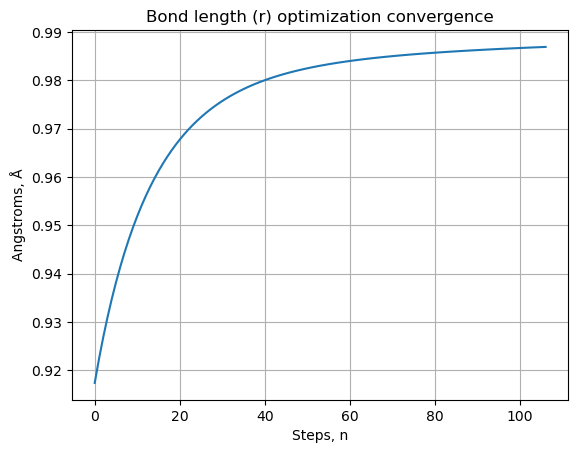

In [10]:
import matplotlib.pyplot as plt
np_bl = np.array(bond_length)
np_ba = np.array(bond_angle)
np_en = np.array(energy_vec)
plt.plot(np_bl)
plt.xlabel("Steps, n")
plt.ylabel("Angstroms, Å")
plt.title("Bond length (r) optimization convergence")
plt.grid(True)

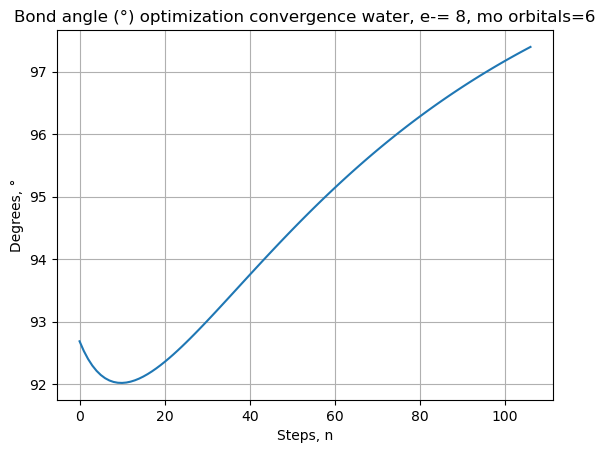

In [9]:
plt.plot(np_ba)
plt.xlabel("Steps, n")
plt.ylabel("Degrees, \u00b0")
plt.title("Bond angle (\u00b0) optimization convergence water, e-= 8, mo orbitals=6")
plt.grid(True)

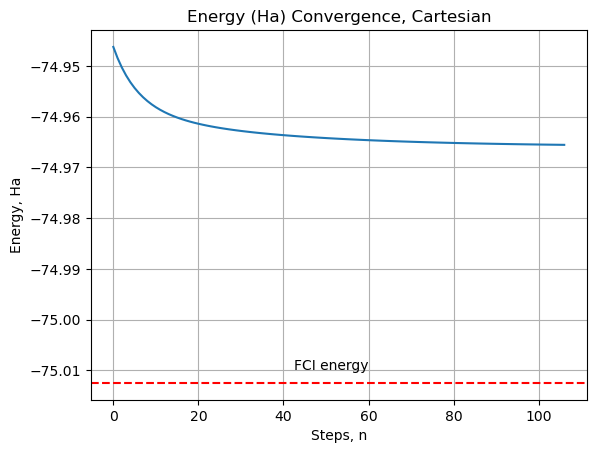

In [15]:
plt.plot(np_en)
plt.xlabel("Steps, n")
plt.ylabel("Energy, Ha")
plt.title("Energy (Ha) Convergence, Cartesian")

plt.axhline(y=-75.01250626334813, color='r', linestyle='--')
plt.text(60, -75.01, 'FCI energy', horizontalalignment='right')

plt.grid(True)

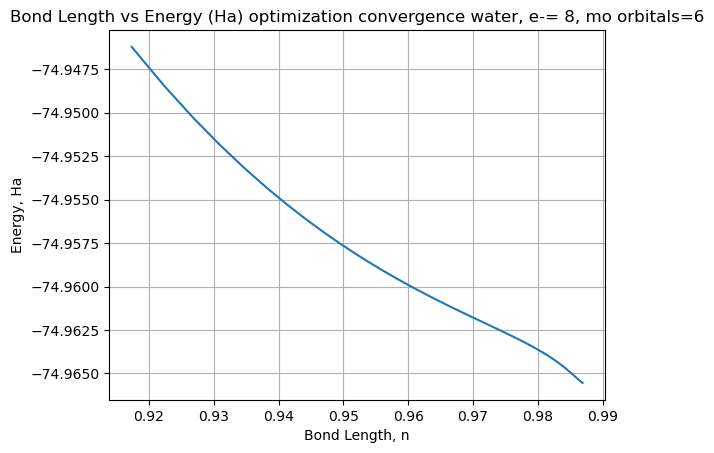

In [11]:
plt.plot(np_bl, np_en)
plt.xlabel("Bond Length, n")
plt.ylabel("Energy, Ha")
plt.title("Bond Length vs Energy (Ha) optimization convergence water, e-= 8, mo orbitals=6")
plt.grid(True)

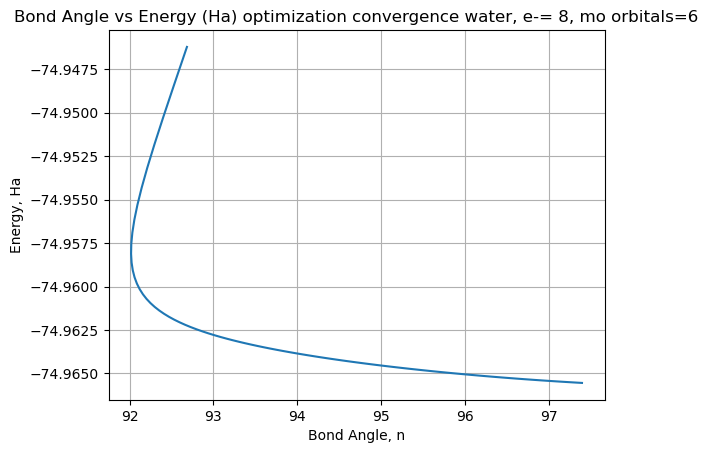

In [12]:
plt.plot(np_ba, np_en)
plt.xlabel("Bond Angle, n")
plt.ylabel("Energy, Ha")
plt.title("Bond Angle vs Energy (Ha) optimization convergence water, e-= 8, mo orbitals=6")
plt.grid(True)

In [19]:
geometry1 = np.array([[0.        ,  0.7581    , -0.5086],
              [-1.49139892,  0.29819887, -1.2393812],
              [-0.68850404,  2.16155953,  0.21671681]], requires_grad=True)

In [20]:
symbols

['O', 'H', 'H']

In [21]:
H = qml.qchem.molecular_hamiltonian(symbols, geometry1)[0]
H_coeffs, H_ops = H.terms()
m = qml.resource.estimate_shots(H_coeffs)
print(f'Shots : {m:.2e}')

Shots : 5.48e+09
